In [2]:
import os
import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
from IPython.display import Markdown, display

In [3]:
def load_embeddings(subject):
    path = '../embeddings/embeddings_' + subject
    normal_embs = np.load(path + '_normal.npy')
    sleepy_embs = np.load(path + '_sleepy.npy')

    return normal_embs, sleepy_embs

In [4]:
# Extracts average embedding in a segment from given embeddigs
def embeddings_segment(embeddings, video_len, segment_len):
    # The amount of frames at the end that are not taken into account
    rest = video_len % segment_len
    num_frames = video_len - rest
    avg_embeddings = []
    acum_embeddings = np.zeros(2048)
    # a blink is counted to a segment,when the blink starts in that segment
    for frame in range(num_frames + 1):
        # if frame % 1000 == 0:
        #     print(frame)
        acum_embeddings = acum_embeddings + np.array(embeddings[frame])
        # only happens at the end of a segment
        if frame % segment_len == 0 and frame != 0:
            avg_embeddings.append(acum_embeddings / segment_len)
            acum_embeddings = np.zeros(2048)
            #print('New segment: ', frame)
    normalized_embeddings = preprocessing.normalize(avg_embeddings, norm='l2')
    return normalized_embeddings

In [84]:
norm_embs, sleep_embs = load_embeddings('sub10')

print(len(norm_embs), len(sleep_embs))
avg_norm_embs = embeddings_segment(norm_embs, len(norm_embs), 46 * 60)
avg_sleep_embs = embeddings_segment(sleep_embs, len(sleep_embs), 46 * 60)

114829 131558


In [85]:
norm_len = len(avg_norm_embs)
sleep_len = len(avg_sleep_embs)

print(norm_len, sleep_len)

41 47


In [86]:
all_embs = list(avg_norm_embs) + list(avg_sleep_embs)

In [87]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pri_comps = pca.fit_transform(all_embs)

pc_normal = pri_comps[:norm_len]
pc_sleep = pri_comps[norm_len:]

In [88]:
print(len(pc_normal[:,0]))

41


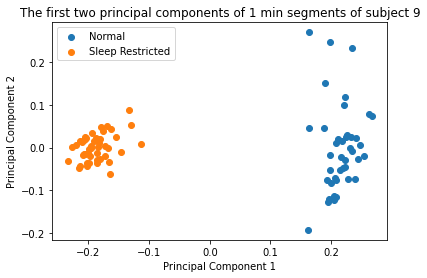

In [89]:
plt.scatter(pc_normal[:,0], pc_normal[:,1], label = 'Normal')
plt.scatter(pc_sleep[:,0], pc_sleep[:,1], label = 'Sleep Restricted')
#plt.scatter(pri_comps[:,0], pri_comps[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('The first two principal components of 1 min segments of subject 9')
plt.legend()
plt.savefig('pc_plot_subject9_norm.jpg')
plt.show()

In [90]:
import os

def make_textfile(embeddings):
    with open('../textfiles/sub10/subject10_1', 'w') as f:
        for row in embeddings:
            first = True
            for value in row:
                if not first:
                    f.write(';')
                else:
                    first = False
                f.write(str(value))
            f.write('\n')
    print('done')
make_textfile(np.array(avg_norm_embs))
print(np.array(avg_norm_embs).shape)

done
(41, 2048)


## Clustering techniques
### DBSCAN

[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0
 3 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


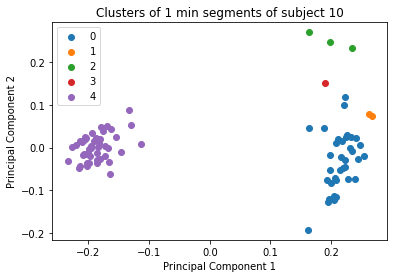

[]


In [91]:
from sklearn.cluster import DBSCAN
from sklearn_extra.cluster import KMedoids
n = 3
#cluster_model = KMedoids(n_clusters=n).fit(np.array(avg_norm_embs))
cluster_model = DBSCAN(eps = 0.25, min_samples = 1).fit(np.array(all_embs))
labels = cluster_model.labels_
uni_labels = np.unique(labels)
print(labels)

all_values = []
for label in uni_labels:
    label_values = []
    for i, emb in enumerate(pri_comps):
        if labels[i] == label:
            label_values.append(list(pri_comps[i]))
    plt.scatter(np.array(label_values)[:,0], np.array(label_values)[:,1], label = str(label))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters of 1 min segments of subject 10')
plt.legend()

plt.savefig('../figures/clusters_sub10.jpg')
plt.show()
print(all_values)

### Evolution of clusters trough time

[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0
 3 0 0 0]


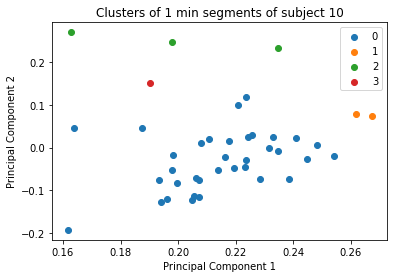

In [92]:
cluster_model = DBSCAN(eps = 0.25, min_samples = 1).fit(np.array(avg_norm_embs))
labels = cluster_model.labels_
uni_labels = np.unique(labels)
print(labels)

all_values = []
for label in uni_labels:
    label_values = []
    for i, emb in enumerate(pc_normal):
        if labels[i] == label:
            label_values.append(list(pc_normal[i]))
    plt.scatter(np.array(label_values)[:,0], np.array(label_values)[:,1], label = str(label))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters of 1 min segments of subject 10')
plt.legend()

plt.savefig('../figures/clusters_sub10_normal.jpg')
plt.show()


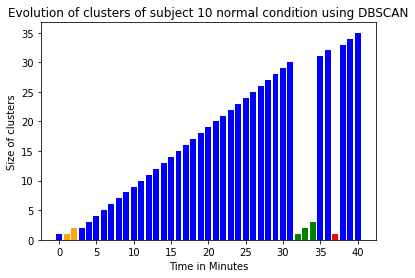

In [93]:
def make_barplot(labels):
    occurences = {}
    y_values = []
    
    all_colors = ['blue', 'orange', 'green', 'red', 'cyan', 'yellow', 'purple', 'olive', 'pink']
    colors = []
    
    for lab in labels:
        if lab in occurences:
            occurences[lab] += 1
        else:
            occurences[lab] = 1
        y_values.append(occurences[lab])
        colors.append(all_colors[lab])
    x_values = range(len(labels))
    
    plt.bar(x_values, y_values, color=colors)
    plt.title("Evolution of clusters of subject 10 normal condition using DBSCAN")
    plt.xlabel("Time in Minutes")
    plt.ylabel("Size of clusters")
    plt.savefig("../figures/clusters_evolution_10_norm.jpg")
    plt.show()

make_barplot(labels)

In [96]:
from sklearn.manifold import TSNE
tsne_data = TSNE().fit_transform(np.array(all_embs))

tsne_normal = tsne_data[:norm_len]
tsne_sleep = tsne_data[norm_len:]
print(len(tsne_normal))

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


41


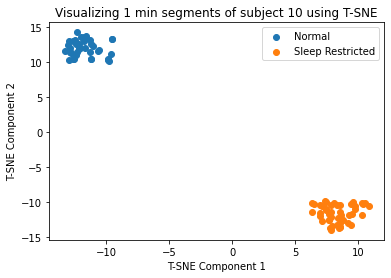

In [95]:
plt.scatter(tsne_normal[:,0], tsne_normal[:,1], label = 'Normal')
plt.scatter(tsne_sleep[:,0], tsne_sleep[:,1], label = 'Sleep Restricted')

plt.xlabel('T-SNE Component 1')
plt.ylabel('T-SNE Component 2')
plt.title('Visualizing 1 min segments of subject 10 using T-SNE')
plt.legend()
plt.savefig('../figures/tsne_10.jpg')
plt.show()

## Multiple subjects analysis

In [20]:
norm_embs10, sleep_embs10 = load_embeddings('sub10')
norm_embs9, sleep_embs9 = load_embeddings('sub9')

avg_norm_embs10 = embeddings_segment(norm_embs10, len(norm_embs10), 46 * 60)
avg_sleep_embs10 = embeddings_segment(sleep_embs10, len(sleep_embs10), 46 * 60)

avg_norm_embs9 = embeddings_segment(norm_embs9, len(norm_embs9), 46 * 60)
avg_sleep_embs9 = embeddings_segment(sleep_embs9, len(sleep_embs9), 46 * 60)

print(len(norm_embs), len(sleep_embs))

all_embs = avg_norm_embs9 + avg_sleep_embs9 + avg_norm_embs10 + avg_sleep_embs10
norm_len9 = len(avg_norm_embs9)
sleep_len9 = norm_len9 + len(avg_sleep_embs9)
norm_len10 = sleep_len9 + len(avg_norm_embs10)
sleep_len10 = norm_len10 + len(avg_sleep_embs10)
print(len(all_embs))
print(sleep_len10)

pca = PCA(n_components=2)
pri_comps_multi = pca.fit_transform(all_embs)

pc_normal9 = pri_comps_multi[:norm_len9]
pc_sleep9 = pri_comps_multi[norm_len9: sleep_len9]
pc_normal10 = pri_comps_multi[sleep_len9:norm_len10]
pc_sleep10 = pri_comps_multi[norm_len10:]

print(len(pc_normal9) + len(pc_sleep9) + len(pc_normal10) + len(pc_sleep10))

114829 131558
114
114
114


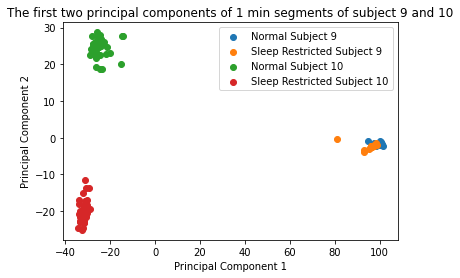

In [21]:
plt.scatter(pc_normal9[:,0], pc_normal9[:,1], label = 'Normal Subject 9')
plt.scatter(pc_sleep9[:,0], pc_sleep9[:,1], label = 'Sleep Restricted Subject 9')
plt.scatter(pc_normal10[:,0], pc_normal10[:,1], label = 'Normal Subject 10')
plt.scatter(pc_sleep10[:,0], pc_sleep10[:,1], label = 'Sleep Restricted Subject 10')
#plt.scatter(pri_comps[:,0], pri_comps[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('The first two principal components of 1 min segments of subject 9 and 10')
plt.legend()
plt.savefig('pc_plot_subj9&10.jpg')
plt.show()